# Gesture Recognition: Rahul Anand
In this group project, we are going to build a 3D model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,Input,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import warnings
import abc
import cv2
warnings.filterwarnings('ignore')

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
os.getcwd()
project_folder='Project_data'

In [5]:
train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())


#### Image Processor
The objective of this function is: Resize the images as per transform_size given by user, or take it as (120,120)

Reason

In the training data we have 2 types of video, where video frame sizes are as (360,360) and (160,120) Therefore to keep things consistent, we build a image processor which perform cropping of the image.

#### Note

Cropping is done as a centered image, i.e., we take the center as the reference and crop the images from both sides. For (360,360) we can use skimage.transform.resize function. However, for (160,120) we will have to some manual processing to crop images by the center.

In [6]:
from skimage.transform import resize
def image_processor(orig_image,transform_size=(120,120)):
    new_image = orig_image
    if orig_image.shape == (360,360,3):
        new_image = resize(orig_image,transform_size)
    else:
        start_row = (orig_image.shape[0] - transform_size[0])//2
        end_row = start_row + transform_size[0]
        
        start_col = (orig_image.shape[1] - transform_size[1])//2
        end_col = start_col + transform_size[1]
        new_image = orig_image[start_row:end_row,start_col:end_col,:]
    return(new_image)

#### Sequence Generator
This function provides a list of frame sequences we would like to use training

Arguments:choiceoflist

choicelist
0 --> range(0,30,1)<br>
1 --> range(0,30,2)<br>
2 --> [0,1,2,3,4,5,6,9,12,15,18,21,24,25,26,27,28,29]
	

In [7]:
def getframeselectionlist(choiceoflist=0):
    if choiceoflist==0:
        return [frame for frame in range(0,30,1)] # Returns 100% of frames, number of frames=30
    elif choiceoflist==1:
        return [frame for frame in range(0,30,2)] # returns 50% of frames, number of frames=15
    elif choiceoflist==2:
                
        frame_sequence=[]
        
        startframesequence=[0,1,2,3,4,5]
        endframesequence=[25,26,27,28,29]
        skip_sequence=3  #
        middleframesequnce=[k for k in range(6,25,skip_sequence)]
        
        frame_sequence.extend(startframesequence)
        frame_sequence.extend(middleframesequnce)
        frame_sequence.extend(endframesequence)
        
        return frame_sequence

### Generator
This is heart of complete training process. It pumps batched data to network during learning and prediction both. The function description is given below

#### Arguments

1. Source Path - Directory path to be considered for reading video/images frames
2. folder_list - Lines from the train_doc we read above.
3. batch_size - The batch_size we want to select.
4. transform_size - The image transformation size we (Default - (120,120)
5. frame_selection_list - frame_list obtained from frame_generator (Default - range(30)).

In [8]:
def generator(source_path,
              folder_list,
              batch_size,
              transform_size = (120,120),
              frame_selection_list = range(30)):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = frame_selection_list
    channels = 3
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t) / batch_size) if len(t) % batch_size == 0 else (len(t) // batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(frame_selection_list),transform_size[0],transform_size[1],channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print(t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = image_processor(image,transform_size)
                    # This is when we are building a Conv3D network
                    image = image/255

                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        # remaining data #
        if len(t) % batch_size != 0:                                      # Execute only if, we need to
            batch_data = np.zeros((len(t) % batch_size,len(frame_selection_list),transform_size[0],transform_size[1],channels))     # fix the last batch size
            batch_labels = np.zeros((len(t) % batch_size,5))              # Similarly, for labels
            for v_idx,folder in enumerate(t[(num_batches*batch_size):]):
                #print(folder.split(';')[0])
                imgs = os.listdir(source_path+"/"+folder.split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path+'/'+folder.split(';')[0]+"/"+imgs[item]).astype(np.float32)
                    image = image_processor(image,transform_size)
                    # This is when we are building a Conv3D network
                    image = image/255

                    batch_data[v_idx,idx,:,:,0] = image[:,:,0]
                    batch_data[v_idx,idx,:,:,1] = image[:,:,1]
                    batch_data[v_idx,idx,:,:,0] = image[:,:,2]
                batch_labels[v_idx,int(folder.split(";")[2])] = 1
            yield batch_data,batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


## Model
Now we will start making different models

### 1. Simple CNN3D model

In [15]:
train_data = train_doc
val_data = val_doc
transform_size = (120,120)
batch_size = 16
num_epochs = 5
frame_selection_list = getframeselectionlist(choiceoflist=0)
model_name = "simpleCNN3D"
input_sample = next(generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              transform_size=transform_size,
                              frame_selection_list=frame_selection_list))
print("Input Sample shape : %s" %(str(input_sample[0].shape)))
model = Sequential()
model.add(Conv3D(16,(3,3,3),padding="same",input_shape=(input_sample[0].shape[1],input_sample[0].shape[2],input_sample[0].shape[3],input_sample[0].shape[4])))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(8,(3,3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(3,3,3)))

model.add(Conv3D(8,(3,3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(input_sample[1].shape[1], activation='softmax'))

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 16
Input Sample shape : (16, 30, 120, 120, 3)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [16]:
optimiser = optimizers.Adam(lr=0.0002)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_10 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 15, 60, 60, 8)     3464      
_________________________________________________________________
activation_11 (Activation)   (None, 15, 60, 60, 8)     0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 5, 20, 20, 8)      0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 5, 20, 20, 8)      1736      
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
train_generator = generator(train_path,
                            train_data, 
                            batch_size=batch_size,
                            transform_size=transform_size,
                            frame_selection_list=frame_selection_list)
val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          transform_size=transform_size,
                          frame_selection_list=frame_selection_list)


#### Setting up extra parameter for Neural Network
##### ModelCheckPoint
We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.

##### ReduceLROnPlateau
If the val_loss value stops improving after patience number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for raeaching global minimum and avoid getting stuch at local minimum.



In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       patience=5, min_lr=0.001,verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [20]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  /mnt/disks/user/project/PROJECT/Project_data/trainEpoch 1/5
 ; batch size = 16
/mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 16
42/42 [==============================] - 182s 4s/step - loss: 1.5451 - categorical_accuracy: 0.3722 - val_loss: 3.2571 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2021-02-0801_33_00.731094/model-00001-1.55079-0.36953-3.25710-0.27000.h5
Epoch 2/5
42/42 [==============================] - 109s 3s/step - loss: 0.9757 - categorical_accuracy: 0.6159 - val_loss: 2.3337 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2021-02-0801_33_00.731094/model-00002-0.96918-0.61840-2.33371-0.39000.h5
Epoch 3/5
42/42 [==============================] - 81s 2s/step - loss: 0.7070 - categorical_accuracy: 0.7339 - val_loss: 2.5649 - val_categorical_accuracy: 0.4300

Epoch 00003: saving model to model_init_2021-02-0801_33_00.731094/model-00003-0.70557-0.73605-2.56494-0.43000.h5
E

Not a very good accuracy, This model was used to check everything is wroking fine.
#### Now repeating some of the above cells for different models

# 2. CNN3D model
**Increasing the complexity of the CNN3D model, adding more layers of CNN **<br>
**Increasing the batch size to decrease the number of steps**<br>
**Reducing the Transform Size**

In [21]:
train_data = train_doc
val_data = val_doc
transform_size = (100,100)
batch_size = 32
num_epochs = 8
frame_selection_list = getframeselectionlist(choiceoflist=0)
model_name = "CNN3D_v2_complex"
input_sample = next(generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              transform_size=transform_size,
                              frame_selection_list=frame_selection_list))
print("Input Sample shape : %s" %(str(input_sample[0].shape)))
model = Sequential()
model.add(Conv3D(16,(3,3,3),padding="same",input_shape=(input_sample[0].shape[1],input_sample[0].shape[2],input_sample[0].shape[3],input_sample[0].shape[4])))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,(3,3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64,(3,3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,(3,3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(input_sample[1].shape[1], activation='softmax'))

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Input Sample shape : (32, 30, 100, 100, 3)


In [22]:
optimiser = optimizers.Adam(lr=0.0002)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 7, 25, 25, 64)     55360     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [23]:
train_generator = generator(train_path,
                            train_data, 
                            batch_size=batch_size,
                            transform_size=transform_size,
                            frame_selection_list=frame_selection_list)
val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          transform_size=transform_size,
                          frame_selection_list=frame_selection_list)


#### Setting up extra parameter for Neural Network
##### ModelCheckPoint
We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.

##### ReduceLROnPlateau
If the val_loss value stops improving after patience number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for raeaching global minimum and avoid getting stuch at local minimum.



In [24]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       patience=5, min_lr=0.001,verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [26]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 32
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Epoch 1/8
21/21 [==============================] - 88s 4s/step - loss: 1.5348 - categorical_accuracy: 0.3732 - val_loss: 8.3137 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-02-0801_33_00.731094/model-00001-1.53243-0.37406-8.31374-0.23000.h5
Epoch 2/8
21/21 [==============================] - 72s 3s/step - loss: 1.1814 - categorical_accuracy: 0.5034 - val_loss: 3.0242 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2021-02-0801_33_00.731094/model-00002-1.17893-0.50377-3.02415-0.26000.h5
Epoch 3/8
21/21 [==============================] - 75s 4s/step - loss: 0.9948 - categorical_accuracy: 0.5943 - val_loss: 6.8883 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-02-0801_33_00.731094/model-00003-0.99473-0.59578-6.88825-0.20000.h5
Epo

####  the accuracy decrease drastically, what we can do is first take our learning high and bring validation close to it

# 3. CNN3D model
**Extremely complex CNN3D model for overlearning of the model**<br>

In [28]:
train_data = train_doc
val_data = val_doc
transform_size = (100,100)
batch_size = 32
num_epochs = 8
frame_selection_list = getframeselectionlist(choiceoflist=0)
model_name = "CNN3D_v2_complex"
input_sample = next(generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              transform_size=transform_size,
                              frame_selection_list=frame_selection_list))
print("Input Sample shape : %s" %(str(input_sample[0].shape)))
model = Sequential()
model.add(Conv3D(16,(3,3,3),padding="same",input_shape=(input_sample[0].shape[1],input_sample[0].shape[2],input_sample[0].shape[3],input_sample[0].shape[4])))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,(3,3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64,(3,3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,(3,3,3),padding="same"))
model.add(Activation("relu"))

model.add(Conv3D(32,(3,3,3),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(input_sample[1].shape[1], activation='softmax'))

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Input Sample shape : (32, 30, 100, 100, 3)


In [29]:
optimiser = optimizers.Adam(lr=0.0002)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_22 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_23 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 7, 25, 25, 64)     55360     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [31]:
train_generator = generator(train_path,
                            train_data, 
                            batch_size=batch_size,
                            transform_size=transform_size,
                            frame_selection_list=frame_selection_list)
val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          transform_size=transform_size,
                          frame_selection_list=frame_selection_list)


#### Setting up extra parameter for Neural Network
##### ModelCheckPoint
We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.

##### ReduceLROnPlateau
If the val_loss value stops improving after patience number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for raeaching global minimum and avoid getting stuch at local minimum.



In [32]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       patience=5, min_lr=0.001,verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [34]:
model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 32
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Epoch 1/8
21/21 [==============================] - 87s 4s/step - loss: 1.6972 - categorical_accuracy: 0.3542 - val_loss: 5.9841 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2021-02-0801_33_00.731094/model-00001-1.70235-0.35143-5.98409-0.24000.h5
Epoch 2/8
21/21 [==============================] - 73s 3s/step - loss: 1.1552 - categorical_accuracy: 0.5343 - val_loss: 4.1461 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2021-02-0801_33_00.731094/model-00002-1.15724-0.53394-4.14609-0.25000.h5
Epoch 3/8
21/21 [==============================] - 76s 4s/step - loss: 0.9216 - categorical_accuracy: 0.6313 - val_loss: 2.1045 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2021-02-0801_33_00.731094/model-00003-0.92078-0.63047-2.10454-0.35000.h5
Epo

In [35]:
import matplotlib.pyplot as plt
### Accuracy graph
plt.plot(model.history["categorical_accuracy"])
plt.plot(model.history["val_categorical_accuracy"])
plt.xlabel("EPOCHS")
plt.ylabel("Percentage")
plt.ylim(0.0,1.0)
plt.legend(["Train","Test"],loc="lower right")
plt.show()


<Figure size 640x480 with 1 Axes>

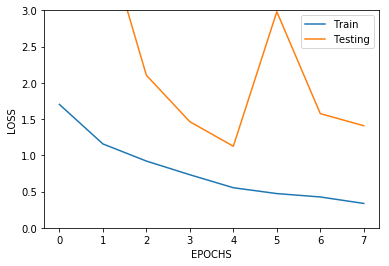

In [36]:
### Loss graph
plt.plot(model.history["loss"])
plt.plot(model.history["val_loss"])
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.ylim(0.0,3.0)
plt.legend(["Train","Testing"],loc="upper right")
plt.show()

# 4. CNN3D model
**Reducing the size of kernel in the model**<br>

In [38]:
train_data = train_doc
val_data = val_doc
transform_size = (100,100)
batch_size = 32
num_epochs = 8
frame_selection_list = getframeselectionlist(choiceoflist=0)
model_name = "CNN3D_v2_complex"
input_sample = next(generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              transform_size=transform_size,
                              frame_selection_list=frame_selection_list))
print("Input Sample shape : %s" %(str(input_sample[0].shape)))
model = Sequential()
model.add(Conv3D(16,(2,2,2),padding="same",input_shape=(input_sample[0].shape[1],input_sample[0].shape[2],input_sample[0].shape[3],input_sample[0].shape[4])))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,(2,2,2),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64,(2,2,2),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,(2,2,2),padding="same"))
model.add(Activation("relu"))

model.add(Conv3D(32,(2,2,2),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(input_sample[1].shape[1], activation='softmax'))

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Input Sample shape : (32, 30, 100, 100, 3)


In [39]:
optimiser = optimizers.Adam(lr=0.0002)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 30, 100, 100, 16)  400       
_________________________________________________________________
activation_32 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
activation_33 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 7, 25, 25, 64)     16448     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [40]:
train_generator = generator(train_path,
                            train_data, 
                            batch_size=batch_size,
                            transform_size=transform_size,
                            frame_selection_list=frame_selection_list)
val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          transform_size=transform_size,
                          frame_selection_list=frame_selection_list)


#### Setting up extra parameter for Neural Network
##### ModelCheckPoint
We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.

##### ReduceLROnPlateau
If the val_loss value stops improving after patience number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for raeaching global minimum and avoid getting stuch at local minimum.



In [41]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       patience=5, min_lr=0.001,verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [42]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [43]:
model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 32
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Epoch 1/8
21/21 [==============================] - 87s 4s/step - loss: 1.6659 - categorical_accuracy: 0.3542 - val_loss: 2.3984 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2021-02-0801_33_00.731094/model-00001-1.66121-0.35596-2.39835-0.37000.h5
Epoch 2/8
21/21 [==============================] - 69s 3s/step - loss: 1.1204 - categorical_accuracy: 0.5589 - val_loss: 1.8715 - val_categorical_accuracy: 0.3400

Epoch 00002: saving model to model_init_2021-02-0801_33_00.731094/model-00002-1.11765-0.56109-1.87154-0.34000.h5
Epoch 3/8
21/21 [==============================] - 73s 3s/step - loss: 0.8833 - categorical_accuracy: 0.6898 - val_loss: 1.5233 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2021-02-0801_33_00.731094/model-00003-0.87219-0.69532-1.52327-0.44000.h5
Epo

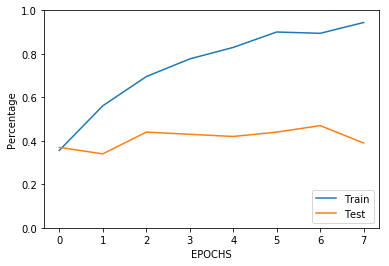

In [44]:
import matplotlib.pyplot as plt
### Accuracy graph
plt.plot(model.history["categorical_accuracy"])
plt.plot(model.history["val_categorical_accuracy"])
plt.xlabel("EPOCHS")
plt.ylabel("Percentage")
plt.ylim(0.0,1.0)
plt.legend(["Train","Test"],loc="lower right")
plt.show()


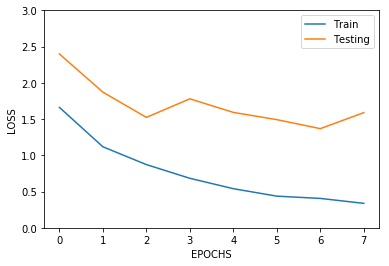

In [45]:
### Loss graph
plt.plot(model.history["loss"])
plt.plot(model.history["val_loss"])
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.ylim(0.0,3.0)
plt.legend(["Train","Testing"],loc="upper right")
plt.show()

#### After decreasing the parameters by 100000 the model still performs as earlier, but our training accuracy has increase, lets continue this model with dropouts.


# 5. CNN3D model
**Using Dropouts**<br>

In [46]:
train_data = train_doc
val_data = val_doc
transform_size = (100,100)
batch_size = 32
num_epochs = 10
frame_selection_list = getframeselectionlist(choiceoflist=0)
model_name = "CNN3D_v2_complex"
input_sample = next(generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              transform_size=transform_size,
                              frame_selection_list=frame_selection_list))
print("Input Sample shape : %s" %(str(input_sample[0].shape)))
model = Sequential()
model.add(Conv3D(16,(2,2,2),padding="same",input_shape=(input_sample[0].shape[1],input_sample[0].shape[2],input_sample[0].shape[3],input_sample[0].shape[4])))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32,(2,2,2),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(64,(2,2,2),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))


model.add(Conv3D(32,(2,2,2),padding="same"))
model.add(Activation("relu"))

model.add(Conv3D(32,(2,2,2),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(input_sample[1].shape[1], activation='softmax'))

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Input Sample shape : (32, 30, 100, 100, 3)


In [48]:
optimiser = optimizers.Adam(lr=0.0002)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 30, 100, 100, 16)  400       
_________________________________________________________________
activation_37 (Activation)   (None, 30, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
activation_38 (Activation)   (None, 15, 50, 50, 32)    0         
_________________________________________________________________
max_pooling3d_34 (MaxPooling (None, 7, 25, 25, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 25, 25, 32)     0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [49]:
train_generator = generator(train_path,
                            train_data, 
                            batch_size=batch_size,
                            transform_size=transform_size,
                            frame_selection_list=frame_selection_list)
val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          transform_size=transform_size,
                          frame_selection_list=frame_selection_list)


#### Setting up extra parameter for Neural Network
##### ModelCheckPoint
We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.

##### ReduceLROnPlateau
If the val_loss value stops improving after patience number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for raeaching global minimum and avoid getting stuch at local minimum.



In [50]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       patience=5, min_lr=0.001,verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [52]:
model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 32
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size =Epoch 1/10
 32
21/21 [==============================] - 86s 4s/step - loss: 2.1469 - categorical_accuracy: 0.2421 - val_loss: 2.3001 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to model_init_2021-02-0801_33_00.731094/model-00001-2.15261-0.24133-2.30014-0.17000.h5
Epoch 2/10
21/21 [==============================] - 71s 3s/step - loss: 1.9076 - categorical_accuracy: 0.2764 - val_loss: 2.4539 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to model_init_2021-02-0801_33_00.731094/model-00002-1.90660-0.27602-2.45394-0.16000.h5
Epoch 3/10
21/21 [==============================] - 73s 3s/step - loss: 1.7965 - categorical_accuracy: 0.3052 - val_loss: 2.6350 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2021-02-0801_33_00.731094/model-00003-1.79963-0.30468-2.63500-0.16000.h5


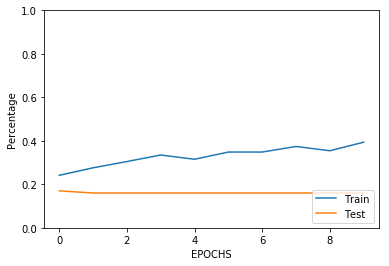

In [55]:
import matplotlib.pyplot as plt
### Accuracy graph
plt.plot(model.history["categorical_accuracy"])
plt.plot(model.history["val_categorical_accuracy"])
plt.xlabel("EPOCHS")
plt.ylabel("Percentage")
plt.ylim(0.0,1.0)
plt.legend(["Train","Test"],loc="lower right")
plt.show()


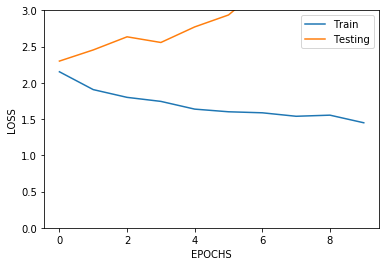

In [56]:
### Loss graph
plt.plot(model.history["loss"])
plt.plot(model.history["val_loss"])
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.ylim(0.0,3.0)
plt.legend(["Train","Testing"],loc="upper right")
plt.show()

#### Using Dropouts doesnt seem to be a very good idea , so removing Dropouts. And now using CNN2d with LSTM

# 6. CNN2D with GRU
**simple model**<br>

In [57]:
train_data = train_doc
val_data = val_doc
transform_size = (100,100)
batch_size = 32
num_epochs = 12
frame_selection_list = getframeselectionlist(choiceoflist=0)
model_name = "CNN2D_LSTM"
input_sample = next(generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              transform_size=transform_size,
                              frame_selection_list=frame_selection_list))
print("Input Sample shape : %s" %(str(input_sample[0].shape)))
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_sample[0].shape[1],input_sample[0].shape[2],input_sample[0].shape[3],input_sample[0].shape[4])))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))



model.add(TimeDistributed(Flatten()))

model.add(GRU(64))

model.add(Dense(64,activation='relu'))
model.add(Dense(input_sample[1].shape[1], activation='softmax'))

Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Input Sample shape : (32, 30, 100, 100, 3)


In [58]:
optimiser = optimizers.Adam(lr=0.0002)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 25, 25, 64)    18496     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [59]:
train_generator = generator(train_path,
                            train_data, 
                            batch_size=batch_size,
                            transform_size=transform_size,
                            frame_selection_list=frame_selection_list)
val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          transform_size=transform_size,
                          frame_selection_list=frame_selection_list)


#### Setting up extra parameter for Neural Network
##### ModelCheckPoint
We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.

##### ReduceLROnPlateau
If the val_loss value stops improving after patience number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for raeaching global minimum and avoid getting stuch at local minimum.



In [60]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       patience=5, min_lr=0.001,verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [61]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [62]:
model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 32
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32
Epoch 1/12
21/21 [==============================] - 87s 4s/step - loss: 1.4069 - categorical_accuracy: 0.4119 - val_loss: 1.2427 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2021-02-0801_33_00.731094/model-00001-1.40657-0.41327-1.24275-0.52000.h5
Epoch 2/12
21/21 [==============================] - 70s 3s/step - loss: 0.8612 - categorical_accuracy: 0.7340 - val_loss: 1.0762 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2021-02-0801_33_00.731094/model-00002-0.85985-0.73454-1.07624-0.63000.h5
Epoch 3/12
21/21 [==============================] - 75s 4s/step - loss: 0.6045 - categorical_accuracy: 0.8558 - val_loss: 0.9862 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2021-02-0801_33_00.731094/model-00003-0.59560-0.86124-0.98623-0.66000.h5


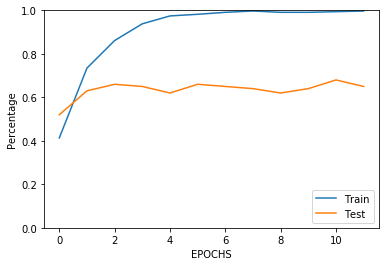

In [63]:
import matplotlib.pyplot as plt
### Accuracy graph
plt.plot(model.history["categorical_accuracy"])
plt.plot(model.history["val_categorical_accuracy"])
plt.xlabel("EPOCHS")
plt.ylabel("Percentage")
plt.ylim(0.0,1.0)
plt.legend(["Train","Test"],loc="lower right")
plt.show()


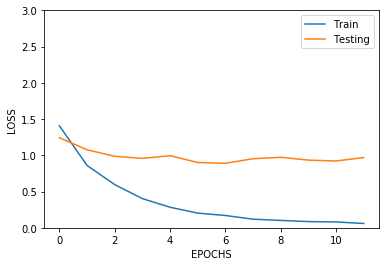

In [64]:
### Loss graph
plt.plot(model.history["loss"])
plt.plot(model.history["val_loss"])
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.ylim(0.0,3.0)
plt.legend(["Train","Testing"],loc="upper right")
plt.show()

#### As we can see our data is till overfitting, what we can do is add augmentation in the data

In [14]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

### 7. CNN3d with Aug

In [66]:

class ModelConv3D7(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [67]:

conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=160,image_width=160)
conv_3d7.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d7_model=conv_3d7.define_model(dense_neurons=256,dropout=0.5)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_42 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_42 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_43 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 10, 80, 80, 32)    128       
__________

In [68]:

print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)


Total Params: 3638981
Epoch 1/20
34/34 [==============================] - 144s 4s/step - loss: 1.8721 - categorical_accuracy: 0.3826 - val_loss: 1.0147 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2021-02-0803_01_45.405982/model-00001-1.89307-0.37557-1.01474-0.60000.h5
Epoch 2/20
34/34 [==============================] - 128s 4s/step - loss: 1.4393 - categorical_accuracy: 0.5000 - val_loss: 0.8639 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2021-02-0803_01_45.405982/model-00002-1.43108-0.50830-0.86388-0.65000.h5
Epoch 3/20
34/34 [==============================] - 132s 4s/step - loss: 1.2465 - categorical_accuracy: 0.5618 - val_loss: 1.3313 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2021-02-0803_01_45.405982/model-00003-1.22579-0.56335-1.33133-0.56000.h5
Epoch 4/20
34/34 [==============================] - 132s 4s/step - loss: 1.1398 - categorical_accuracy: 0.6056 - val_loss: 2.1268 - val_categ

#### This model gives very good results, lets try to achieve with lesser parameters

### Model 8 -CNN3d Adding more layers

In [69]:
class ModelConv3D8(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [72]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=15)
conv_3d8_model=conv_3d8.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_54 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 8, 60, 60, 32)     128       
__________

In [73]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 2549541
Epoch 1/15
21/21 [==============================] - 103s 5s/step - loss: 2.2220 - categorical_accuracy: 0.3036 - val_loss: 2.1349 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2021-02-0803_49_30.733147/model-00001-2.22094-0.30468-2.13492-0.44000.h5
Epoch 2/15
21/21 [==============================] - 78s 4s/step - loss: 1.6416 - categorical_accuracy: 0.4406 - val_loss: 1.3721 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2021-02-0803_49_30.733147/model-00002-1.64304-0.44042-1.37208-0.51000.h5
Epoch 3/15
21/21 [==============================] - 89s 4s/step - loss: 1.4547 - categorical_accuracy: 0.4925 - val_loss: 1.0027 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2021-02-0803_49_30.733147/model-00003-1.46054-0.49095-1.00272-0.65000.h5
Epoch 4/15
21/21 [==============================] - 88s 4s/step - loss: 1.2183 - categorical_accuracy: 0.5646 - val_loss: 1.1338 - val_categori

### Lets Try Augmented with simple GRU

## Model 10 CNN2d and GRU

In [74]:
class RNNCNN10(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [75]:
rnn_cnn10=RNNCNN10()
rnn_cnn10.initialize_path(project_folder)
rnn_cnn10.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn10.initialize_hyperparams(frames_to_sample=18,batch_size=32,num_epochs=12)
rnn_cnn10_model=rnn_cnn10.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 28800)         0         
__________

In [76]:
print("Total Params:", rnn_cnn10_model.count_params())
history_model10=rnn_cnn10.train_model(rnn_cnn10_model,augment_data=True)

Total Params: 11131173
Epoch 1/12
21/21 [==============================] - 107s 5s/step - loss: 1.4829 - categorical_accuracy: 0.3655 - val_loss: 1.1793 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2021-02-0804_14_47.851883/model-00001-1.48628-0.36350-1.17926-0.55000.h5
Epoch 2/12
21/21 [==============================] - 92s 4s/step - loss: 1.1495 - categorical_accuracy: 0.5332 - val_loss: 1.0337 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2021-02-0804_14_47.851883/model-00002-1.14916-0.53394-1.03371-0.63000.h5
Epoch 3/12
21/21 [==============================] - 97s 5s/step - loss: 0.9770 - categorical_accuracy: 0.6223 - val_loss: 1.0030 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2021-02-0804_14_47.851883/model-00003-0.97716-0.62217-1.00297-0.63000.h5
Epoch 4/12
21/21 [==============================] - 97s 5s/step - loss: 0.8199 - categorical_accuracy: 0.6958 - val_loss: 0.9868 - val_categor

## Model 11 CNN2d and GRU with simpler architecture

In [82]:
class RNNCNN11(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(128))
        model.add(Dropout(dropout))
        #model.add(GRU(128))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dense(dense_neurons,activation='relu'))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [83]:
rnn_cnn11=RNNCNN11()
rnn_cnn11.initialize_path(project_folder)
rnn_cnn11.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn11.initialize_hyperparams(frames_to_sample=18,batch_size=32,num_epochs=22)
rnn_cnn11_model=rnn_cnn11.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_47 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_48 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_49 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_51 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_52 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [84]:
print("Total Params:", rnn_cnn11_model.count_params())
history_model11=rnn_cnn11.train_model(rnn_cnn11_model,augment_data=True)

Total Params: 2606565
Epoch 1/22
21/21 [==============================] - 108s 5s/step - loss: 1.5535 - categorical_accuracy: 0.3073 - val_loss: 1.4348 - val_categorical_accuracy: 0.4100

Epoch 00001: saving model to model_init_2021-02-0805_42_12.453972/model-00001-1.55581-0.30618-1.43479-0.41000.h5
Epoch 2/22
21/21 [==============================] - 91s 4s/step - loss: 1.3254 - categorical_accuracy: 0.4687 - val_loss: 1.2110 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2021-02-0805_42_12.453972/model-00002-1.32485-0.46833-1.21101-0.56000.h5
Epoch 3/22
21/21 [==============================] - 100s 5s/step - loss: 1.1572 - categorical_accuracy: 0.5137 - val_loss: 1.1103 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2021-02-0805_42_12.453972/model-00003-1.15744-0.51357-1.11030-0.59000.h5
Epoch 4/22
21/21 [==============================] - 99s 5s/step - loss: 0.9692 - categorical_accuracy: 0.6335 - val_loss: 0.9655 - val_categor

#### Till now this is one of the best training and validation accuracy achieved

### Lets use Transfer Learning 

### Model 12 with mobilenet v2


In [10]:
from keras.applications import MobileNetV2

In [11]:
mobilenetV2_transfer = MobileNetV2(weights='imagenet', include_top=False)


In [89]:
class RNNCNN_mobile_net(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenetV2_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [90]:
rnn_cnn_mn_v2=RNNCNN_mobile_net()
rnn_cnn_mn_v2.initialize_path(project_folder)
rnn_cnn_mn_v2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_mn_v2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=10)
rnn_cnn_mn_v2_model=rnn_cnn_mn_v2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_mn_v2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_60 (TimeDis (None, 16, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_61 (TimeDis (None, 16, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_62 (TimeDis (None, 16, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_63 (TimeDis (None, 16, 5120)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               2687488   
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 128)               16512     
__________

In [91]:
print("Total Params:", rnn_cnn_mn_v2_model.count_params())
history_model12=rnn_cnn_mn_v2.train_model(rnn_cnn_mn_v2_model,augment_data=True)

Total Params: 4967749
Epoch 1/10
133/133 [==============================] - 104s 781ms/step - loss: 1.4712 - categorical_accuracy: 0.3727 - val_loss: 1.4045 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2021-02-0806_24_25.928698/model-00001-1.47020-0.37330-1.40447-0.37000.h5
Epoch 2/10
133/133 [==============================] - 80s 604ms/step - loss: 1.2128 - categorical_accuracy: 0.4830 - val_loss: 1.2493 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2021-02-0806_24_25.928698/model-00002-1.21258-0.48341-1.24933-0.47000.h5
Epoch 3/10
133/133 [==============================] - 87s 653ms/step - loss: 1.1243 - categorical_accuracy: 0.5353 - val_loss: 1.4023 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_init_2021-02-0806_24_25.928698/model-00003-1.12344-0.53544-1.40227-0.40000.h5
Epoch 4/10
133/133 [==============================] - 83s 621ms/step - loss: 1.0233 - categorical_accuracy: 0.5787 - val_loss: 1

#### PRe trained weights doesnt give good results, lets try and train all the weights

### Model 13 with mobilenet v2 training all the weights

In [12]:
mobilenetV2_transfer = MobileNetV2(weights='imagenet', include_top=False)


In [15]:
          
class RNNCNN_tain_weights(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenetV2_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
rnn_cnn_13=RNNCNN_tain_weights()
rnn_cnn_13.initialize_path(project_folder)
rnn_cnn_13.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_13.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=10)
rnn_cnn_13_model=rnn_cnn_13.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_13_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 5120)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               2015616   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
__________

In [17]:
print("Total Params:", rnn_cnn_13_model.count_params())
history_model13=rnn_cnn_13.train_model(rnn_cnn_13_model,augment_data=True)

Total Params: 4295877
Epoch 1/10
133/133 [==============================] - 115s 864ms/step - loss: 1.3298 - categorical_accuracy: 0.4639 - val_loss: 0.8398 - val_categorical_accuracy: 0.6900

Epoch 00001: saving model to model_init_2021-02-0806_58_46.674261/model-00001-1.32957-0.46380-0.83982-0.69000.h5
Epoch 2/10
133/133 [==============================] - 97s 730ms/step - loss: 1.0957 - categorical_accuracy: 0.5582 - val_loss: 1.1752 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2021-02-0806_58_46.674261/model-00002-1.09208-0.55882-1.17523-0.46000.h5
Epoch 3/10
133/133 [==============================] - 95s 712ms/step - loss: 0.9375 - categorical_accuracy: 0.6190 - val_loss: 1.1691 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2021-02-0806_58_46.674261/model-00003-0.93885-0.61840-1.16911-0.52000.h5
Epoch 4/10
133/133 [==============================] - 97s 727ms/step - loss: 0.7708 - categorical_accuracy: 0.6840 - val_loss: 0

### Lets Try Mobile net V1

## Model 14 with mobilenet v1 training all the weights

In [18]:

from keras.applications import mobilenet
mobilenet_transfer =  mobilenet.MobileNet(weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 1s 0us/step


In [19]:
class RNNCNN_tain_weights_14(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
rnn_cnn_14=RNNCNN_tain_weights()
rnn_cnn_14.initialize_path(project_folder)
rnn_cnn_14.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_14.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=15)
rnn_cnn_14_model=rnn_cnn_14.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_14_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 16, 4, 4, 1280)    2257984   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 4, 4, 1280)    5120      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 2, 2, 1280)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 5120)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               2015616   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
__________

In [21]:
print("Total Params:", rnn_cnn_14_model.count_params())
history_model14=rnn_cnn_14.train_model(rnn_cnn_14_model,augment_data=True)

Total Params: 4295877
Epoch 1/15
133/133 [==============================] - 112s 844ms/step - loss: 0.9503 - categorical_accuracy: 0.6461 - val_loss: 1.0527 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2021-02-0807_27_51.966986/model-00001-0.95046-0.64555-1.05265-0.58000.h5
Epoch 2/15
133/133 [==============================] - 96s 725ms/step - loss: 0.9476 - categorical_accuracy: 0.6196 - val_loss: 1.5255 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2021-02-0807_27_51.966986/model-00002-0.94260-0.62142-1.52546-0.43000.h5
Epoch 3/15
133/133 [==============================] - 94s 707ms/step - loss: 0.8016 - categorical_accuracy: 0.6531 - val_loss: 1.7509 - val_categorical_accuracy: 0.3200

Epoch 00003: saving model to model_init_2021-02-0807_27_51.966986/model-00003-0.80260-0.65309-1.75094-0.32000.h5
Epoch 4/15
133/133 [==============================] - 94s 709ms/step - loss: 0.9027 - categorical_accuracy: 0.6190 - val_loss: 1

### Model 15 The above model a good accuracy but it the model size is 50 MB , so lets retrain model 11 with more epochs and lesser layers

In [22]:
class RNNCNN15(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(128))
        model.add(Dropout(dropout))
        #model.add(GRU(128))

        model.add(Dense(dense_neurons,activation='relu'))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
rnn_cnn15=RNNCNN15()
rnn_cnn15.initialize_path(project_folder)
rnn_cnn15.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn15.initialize_hyperparams(frames_to_sample=18,batch_size=32,num_epochs=18)
rnn_cnn15_model=rnn_cnn15.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn15_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_11 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [24]:
print("Total Params:", rnn_cnn15_model.count_params())
history_model15=rnn_cnn15.train_model(rnn_cnn15_model,augment_data=True)

Total Params: 2573541
Epoch 1/18
21/21 [==============================] - 112s 5s/step - loss: 1.4131 - categorical_accuracy: 0.3744 - val_loss: 1.1419 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2021-02-0808_22_48.607015/model-00001-1.41558-0.37330-1.14195-0.55000.h5
Epoch 2/18
21/21 [==============================] - 89s 4s/step - loss: 0.9820 - categorical_accuracy: 0.6219 - val_loss: 0.9366 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to model_init_2021-02-0808_22_48.607015/model-00002-0.97911-0.62293-0.93657-0.70000.h5
Epoch 3/18
21/21 [==============================] - 99s 5s/step - loss: 0.7838 - categorical_accuracy: 0.7124 - val_loss: 0.9905 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model_init_2021-02-0808_22_48.607015/model-00003-0.78410-0.71116-0.99053-0.60000.h5
Epoch 4/18
21/21 [==============================] - 99s 5s/step - loss: 0.6161 - categorical_accuracy: 0.7915 - val_loss: 0.8702 - val_categori

### Model 16, with less layers

In [30]:
class RNNCNN16(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        #model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(128))
        model.add(Dropout(dropout))
        #model.add(GRU(128))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
rnn_cnn16=RNNCNN16()
rnn_cnn16.initialize_path(project_folder)
rnn_cnn16.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn16.initialize_hyperparams(frames_to_sample=18,batch_size=32,num_epochs=18)
rnn_cnn16_model=rnn_cnn16.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_58 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_59 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_60 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_61 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_62 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_63 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_64 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [32]:
print("Total Params:", rnn_cnn16_model.count_params())
history_model16=rnn_cnn16.train_model(rnn_cnn16_model,augment_data=True)

Total Params: 8455269
Epoch 1/18
21/21 [==============================] - 108s 5s/step - loss: 1.2558 - categorical_accuracy: 0.5314 - val_loss: 1.0492 - val_categorical_accuracy: 0.6600

Epoch 00001: saving model to model_init_2021-02-0808_59_00.024434/model-00001-1.25996-0.53017-1.04916-0.66000.h5
Epoch 2/18
21/21 [==============================] - 90s 4s/step - loss: 0.4482 - categorical_accuracy: 0.8345 - val_loss: 0.8395 - val_categorical_accuracy: 0.6800

Epoch 00002: saving model to model_init_2021-02-0808_59_00.024434/model-00002-0.44879-0.83484-0.83951-0.68000.h5
Epoch 3/18
21/21 [==============================] - 99s 5s/step - loss: 0.2211 - categorical_accuracy: 0.9326 - val_loss: 0.8281 - val_categorical_accuracy: 0.6800

Epoch 00003: saving model to model_init_2021-02-0808_59_00.024434/model-00003-0.22047-0.93288-0.82813-0.68000.h5
Epoch 4/18
21/21 [==============================] - 99s 5s/step - loss: 0.1790 - categorical_accuracy: 0.9429 - val_loss: 0.8357 - val_categori

### REtraining model 7 with higher epoch

In [33]:

class ModelConv3D17(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:

conv_3d17=ModelConv3D17()
conv_3d17.initialize_path(project_folder)
conv_3d17.initialize_image_properties(image_height=160,image_width=160)
conv_3d17.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d17_model=conv_3d17.define_model(dense_neurons=256,dropout=0.5)
conv_3d17_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 10, 80, 80, 32)    128       
__________

In [35]:

print("Total Params:", conv_3d17_model.count_params())
history_model17=conv_3d17.train_model(conv_3d17_model,augment_data=True)


Total Params: 3638981
Epoch 1/30
34/34 [==============================] - 161s 5s/step - loss: 1.9077 - categorical_accuracy: 0.3786 - val_loss: 2.4778 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2021-02-0809_28_54.580541/model-00001-1.91504-0.37557-2.47784-0.42000.h5
Epoch 2/30
34/34 [==============================] - 122s 4s/step - loss: 1.3692 - categorical_accuracy: 0.5239 - val_loss: 1.0299 - val_categorical_accuracy: 0.5800

Epoch 00002: saving model to model_init_2021-02-0809_28_54.580541/model-00002-1.39126-0.52036-1.02993-0.58000.h5
Epoch 3/30
34/34 [==============================] - 134s 4s/step - loss: 1.2076 - categorical_accuracy: 0.5883 - val_loss: 0.9487 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2021-02-0809_28_54.580541/model-00003-1.18657-0.59050-0.94872-0.66000.h5
Epoch 4/30
34/34 [==============================] - 133s 4s/step - loss: 1.0710 - categorical_accuracy: 0.6133 - val_loss: 1.2644 - val_categ

### End of Notebook